# RAG & Prompt

In [1]:
# (Colab) AI 논술 멘토 RAG 파이프라인 구축에 필요한 라이브러리 설치
%pip install -q langchain langchain-openai pypdf faiss-cpu sentence-transformers langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.7/309.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

In [2]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

print("✅ API 키 설정이 완료되었습니다. 이제 OpenAI와 통신할 준비가 끝났습니다!")

✅ API 키 설정이 완료되었습니다. 이제 OpenAI와 통신할 준비가 끝났습니다!


In [3]:
%pip install -q gdown

In [4]:
# 1. 데이터 다운로드
!gdown --id 1ys2KBmoKhCoWcWCebINeO6V94Tp9eLiR -O hufs_2023_1.json

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ys2KBmoKhCoWcWCebINeO6V94Tp9eLiR
To: /content/hufs_2023_1.json
100% 9.50k/9.50k [00:00<00:00, 21.6MB/s]


## 일반적인 분석 챗봇

In [5]:
# (Colab) 더미 데이터 다운로드 및 구조화

import json
from langchain_core.documents import Document

# 2. JSON 파일 로드 및 내용 확인
with open('hufs_2023_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print("--- JSON 파일 키 확인 ---")
print(data.keys())
print("\n--- 'question_id' 내용 확인 ---")
print(data.get('question_id'))
print("\n--- 'intended_purpose' 내용 일부 확인 ---")
print(data.get('intended_purpose')[:200] + "...") # 내용이 기니 일부만 출력

# 3. 논리적 단위로 분해하고 메타데이터 추가
# 이 JSON 파일은 하나의 시험 전체에 대한 내용이므로, content_type별로 문서를 분리
structured_docs = []
base_metadata = {
    "university": "한국외국어대학교",
    "year": 2023,
    "subject": "인문논술"
}

# content_type과 해당 내용을 매핑
content_map = {
    "출제의도": data.get("intended_purpose"),
    "채점기준": data.get("grading_criteria"),
    "모범답안": data.get("sample_answer")
}

for content_type, content in content_map.items():
    if content: # 내용이 비어있지 않은 경우에만 처리
        # 새로운 Document 객체를 만들고 메타데이터를 결합
        doc = Document(
            page_content=content,
            metadata={
                **base_metadata,
                "content_type": content_type,
                "question_id": data.get("question_id")
            }
        )
        structured_docs.append(doc)

# 4. 최종 결과 확인
print("\n--- 구조화된 문서 조각 생성 결과 ---")
print(f"총 {len(structured_docs)}개의 논리적 문서 조각을 생성했습니다.")
print("\n[첫 번째 문서 조각 샘플]")
print(structured_docs[0])

--- JSON 파일 키 확인 ---
dict_keys(['question_id', 'intended_purpose', 'grading_criteria', 'sample_answer'])

--- 'question_id' 내용 확인 ---
2023_외대_인문_1

--- 'intended_purpose' 내용 일부 확인 ---

[문제 1]에서는 제시문 (가)부터 (바)까지의 네 개의 제시문을 읽은 후 제시문이 말하는 바를 ‘단일 정체성’과 ‘다중 정체성’의 
두 핵심어 기준으로 분류할 수 있는지 평가하고자 하였다. 또한 네 개의 제시문을 각각 요약하게 함으로써 핵심어를 중심으
로 한 요지 파악 능력을 측정하고자 하였다. 정체성 인식을 기준으로 글을 분류하면 (가),(다),(바)...

--- 구조화된 문서 조각 생성 결과 ---
총 3개의 논리적 문서 조각을 생성했습니다.

[첫 번째 문서 조각 샘플]
page_content='
[문제 1]에서는 제시문 (가)부터 (바)까지의 네 개의 제시문을 읽은 후 제시문이 말하는 바를 ‘단일 정체성’과 ‘다중 정체성’의 
두 핵심어 기준으로 분류할 수 있는지 평가하고자 하였다. 또한 네 개의 제시문을 각각 요약하게 함으로써 핵심어를 중심으
로 한 요지 파악 능력을 측정하고자 하였다. 정체성 인식을 기준으로 글을 분류하면 (가),(다),(바)는 단일 정체성에 해당하며 
(나),(라),(마)는 다중 정체성에 해당한다.
[문제 2]에서는 [문제 1]에서 제시된 두 개념인 단일 정체성과 다중 정체성을 확장해서 이해할 수 있는지를 파악하고자 하였다. 
이를 위해 제시문(바)의 통일신라의 경우, 옛 신라 고유의 국가 정체성 대신 고구려인, 백제인까지 하나로 묶기 위한 삼한일통의
식을 정립한 뒤 이를 바탕으로 삼국유민 통합정책을 추진하였다. <보기>에서 영국의 경우, 유럽시민이라는 공동의 정체성보다, 
오래 전부터 형성되어 온 자국의 정체성을 인정하는 경향이 강했고, 이는 브렉시트에 이르는 정책으로 연결되었다. 국가발전의 
관점에서

In [6]:
# (Colab) 구조화된 문서를 임베딩하고 벡터 데이터베이스에 저장

# 1. '의미 번역기'(임베딩 모델) 준비
from langchain_community.embeddings import HuggingFaceEmbeddings
import torch

# 2. 사용 가능한 장치 확인 (GPU가 있으면 'cuda', 없으면 'cpu')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"현재 사용 가능한 장치: {device}")

# 'ko-sbert-nli' 모델을 불러오되, 장치 설정을 위에서 확인한 device로 지정
embedding_model = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sbert-nli",
    model_kwargs={'device': device},
    encode_kwargs={'normalize_embeddings': True},
)

# 3. '초고속 디지털 도서관'(벡터 데이터베이스) 준비
from langchain_community.vectorstores import FAISS

print("\n구조화된 문서 조각들을 벡터로 변환하여 DB에 저장합니다...")

# 4. 문서 조각들을 벡터로 변환하여 FAISS 벡터 DB에 저장
vector_db = FAISS.from_documents(structured_docs, embedding_model)

print("✅ 벡터 데이터베이스 구축이 완료되었습니다!")

현재 사용 가능한 장치: cpu


/tmp/ipython-input-6-2729903673.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


구조화된 문서 조각들을 벡터로 변환하여 DB에 저장합니다...
✅ 벡터 데이터베이스 구축이 완료되었습니다!


In [7]:
# (Colab) RAG 파이프라인을 생성하고, 실제 질문으로 테스트

# 1. 필요한 라이브러리 임포트
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# 2. '검색기'(Retriever) 준비
retriever = vector_db.as_retriever()

# 3. 프롬프트 준비
template = """
[역할]
당신은 대한민국 대학교의 논술 기출문제를 분석하고 설명하는 'AI 논술 멘토'입니다.
당신의 임무는 사용자의 질문에 대해, 제공된 '참고 자료' 안에서만 정보를 찾아 명확하고 친절하게 답변하는 것입니다.

[작업 절차]
1. 사용자의 '질문'을 정확히 이해합니다.
2. 질문과 가장 관련 있는 내용을 '참고 자료'에서 찾습니다.
3. 찾아낸 내용을 바탕으로, 논리적으로 답변을 구성합니다.
4. 만약 '참고 자료'에서 답변을 찾을 수 없다면, 절대 추측하지 말고 "제공된 자료에서는 해당 내용을 찾을 수 없습니다."라고 답변합니다.

[참고 자료]
{context}

[질문]
{question}

[답변]
"""
prompt = ChatPromptTemplate.from_template(template)

# 4. LLM
llm = ChatOpenAI(model_name="gpt-4.1-nano", temperature=0)

# 5. RAG 체인
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("✅ RAG 파이프라인이 완성되었습니다. 이제 질문을 던져보세요!")

# 6. 테스트 질문 실행
question = "2023년 외대 인문논술 1번 문제의 출제 의도는 뭐야?"
print(f"\n[질문]: {question}")

response = rag_chain.invoke(question)
print(f"\n[AI 멘토의 답변]:\n{response}")

✅ RAG 파이프라인이 완성되었습니다. 이제 질문을 던져보세요!

[질문]: 2023년 외대 인문논술 1번 문제의 출제 의도는 뭐야?

[AI 멘토의 답변]:
제공된 자료에서는 2023년 외대 인문논술 1번 문제의 출제 의도를 다음과 같이 파악할 수 있습니다. 문제 1에서는 제시문들이 ‘단일 정체성’과 ‘다중 정체성’이라는 두 핵심어를 기준으로 분류할 수 있는지 평가하고, 각각의 제시문을 요약하여 핵심 내용을 파악하는 능력을 측정하는 것이 목적입니다. 이를 통해 학생들이 정체성 인식에 대한 이해와 분류 능력을 평가하려는 의도를 드러내고 있습니다.

또한, 문제 2에서는 이러한 정체성 개념을 확장하여, 통일신라와 영국의 사례를 통해 국가 정체성과 발전 전략의 차이를 분석하게 함으로써, 정체성 개념이 역사적·현대적 맥락에서 어떻게 작용하는지 깊이 이해하는 능력을 평가하려는 의도입니다. 이를 통해 학생들이 정체성 개념의 확장적 이해와 국가 발전과의 연관성을 논리적으로 분석하는 능력을 기르도록 유도하는 것이 출제 의도입니다.

마지막으로, 문제 3에서는 다문화 정책과 정체성, 그리고 정책이 가져올 긍정적 효과를 분석하는 과정을 통해, 학생들이 정체성 인식과 정책 방향의 연관성을 이해하고, 구체적 사례를 바탕으로 논리적 추론 능력을 평가하려는 의도를 가지고 있습니다.

종합적으로, 이 문제들은 정체성 개념에 대한 이해와 분류, 확장적 사고, 그리고 정책적 적용 능력을 종합적으로 평가하여, 학생들이 인문학적 사고력과 논리적 분석 능력을 갖추었는지 확인하려는 출제 의도라고 할 수 있습니다.


## OCR 탑재 분석 및 첨삭 봇

In [8]:
# (Colab) 더미 데이터 다운로드 및 구조화

import json
from langchain_core.documents import Document

# 2. JSON 파일 로드 및 내용 확인
with open('hufs_2023_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print("--- JSON 파일 키 확인 ---")
print(data.keys())
print("\n--- 'question_id' 내용 확인 ---")
print(data.get('question_id'))
print("\n--- 'intended_purpose' 내용 일부 확인 ---")
print(data.get('intended_purpose')[:200] + "...") # 내용이 기니 일부만 출력

# 3. 논리적 단위로 분해하고 메타데이터 추가
# 이 JSON 파일은 하나의 시험 전체에 대한 내용이므로, content_type별로 문서를 분리
structured_docs = []
base_metadata = {
    "university": "한국외국어대학교",
    "year": 2023,
    "subject": "인문논술"
}

# content_type과 해당 내용을 매핑
content_map = {
    "출제의도": data.get("intended_purpose"),
    "채점기준": data.get("grading_criteria"),
    "모범답안": data.get("sample_answer")
}

for content_type, content in content_map.items():
    if content: # 내용이 비어있지 않은 경우에만 처리
        # 새로운 Document 객체를 만들고 메타데이터를 결합
        doc = Document(
            page_content=content,
            metadata={
                **base_metadata,
                "content_type": content_type,
                "question_id": data.get("question_id")
            }
        )
        structured_docs.append(doc)

# 4. 최종 결과 확인
print("\n--- 구조화된 문서 조각 생성 결과 ---")
print(f"총 {len(structured_docs)}개의 논리적 문서 조각을 생성했습니다.")
print("\n[첫 번째 문서 조각 샘플]")
print(structured_docs[0])

--- JSON 파일 키 확인 ---
dict_keys(['question_id', 'intended_purpose', 'grading_criteria', 'sample_answer'])

--- 'question_id' 내용 확인 ---
2023_외대_인문_1

--- 'intended_purpose' 내용 일부 확인 ---

[문제 1]에서는 제시문 (가)부터 (바)까지의 네 개의 제시문을 읽은 후 제시문이 말하는 바를 ‘단일 정체성’과 ‘다중 정체성’의 
두 핵심어 기준으로 분류할 수 있는지 평가하고자 하였다. 또한 네 개의 제시문을 각각 요약하게 함으로써 핵심어를 중심으
로 한 요지 파악 능력을 측정하고자 하였다. 정체성 인식을 기준으로 글을 분류하면 (가),(다),(바)...

--- 구조화된 문서 조각 생성 결과 ---
총 3개의 논리적 문서 조각을 생성했습니다.

[첫 번째 문서 조각 샘플]
page_content='
[문제 1]에서는 제시문 (가)부터 (바)까지의 네 개의 제시문을 읽은 후 제시문이 말하는 바를 ‘단일 정체성’과 ‘다중 정체성’의 
두 핵심어 기준으로 분류할 수 있는지 평가하고자 하였다. 또한 네 개의 제시문을 각각 요약하게 함으로써 핵심어를 중심으
로 한 요지 파악 능력을 측정하고자 하였다. 정체성 인식을 기준으로 글을 분류하면 (가),(다),(바)는 단일 정체성에 해당하며 
(나),(라),(마)는 다중 정체성에 해당한다.
[문제 2]에서는 [문제 1]에서 제시된 두 개념인 단일 정체성과 다중 정체성을 확장해서 이해할 수 있는지를 파악하고자 하였다. 
이를 위해 제시문(바)의 통일신라의 경우, 옛 신라 고유의 국가 정체성 대신 고구려인, 백제인까지 하나로 묶기 위한 삼한일통의
식을 정립한 뒤 이를 바탕으로 삼국유민 통합정책을 추진하였다. <보기>에서 영국의 경우, 유럽시민이라는 공동의 정체성보다, 
오래 전부터 형성되어 온 자국의 정체성을 인정하는 경향이 강했고, 이는 브렉시트에 이르는 정책으로 연결되었다. 국가발전의 
관점에서

In [9]:
# (Colab) 1. OCR에 필요한 Tesseract 라이브러리 설치

# Tesseract OCR 엔진과 한국어 언어 팩을 시스템에 설치합니다.
!sudo apt-get install tesseract-ocr
!sudo apt-get install tesseract-ocr-kor

# 파이썬에서 Tesseract를 쉽게 사용할 수 있도록 해주는 라이브러리를 설치합니다.
%pip install -q pytesseract

print("✅ Tesseract OCR 설치가 완료되었습니다.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,052 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1.1 [1,052 kB]
Fetched 1,052 kB in 0s (8,506 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize fro

테스트용 손글씨 이미지로 OCR을 실행합니다...
이미지 URL: https://scontent-gmp1-1.xx.fbcdn.net/v/t1.6435-9/70258633_2630183167067192_3990673398563864576_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=33274f&_nc_ohc=z4R6LUqukO8Q7kNvwF-ZQ7c&_nc_oc=AdkxdvIg3bijX1cjsNQtlqQketOiuH9RBnFDEJUO5mNuAcjEHo8My7lyMpZBQtTidb8&_nc_zt=23&_nc_ht=scontent-gmp1-1.xx&_nc_gid=XwnpjwpuKN0aMcRc5N5sQA&oh=00_AfTe4WhuPdObFOcvc2PQV_AtI17K-X3tjJFJtgyE_DAkNw&oe=689C5179


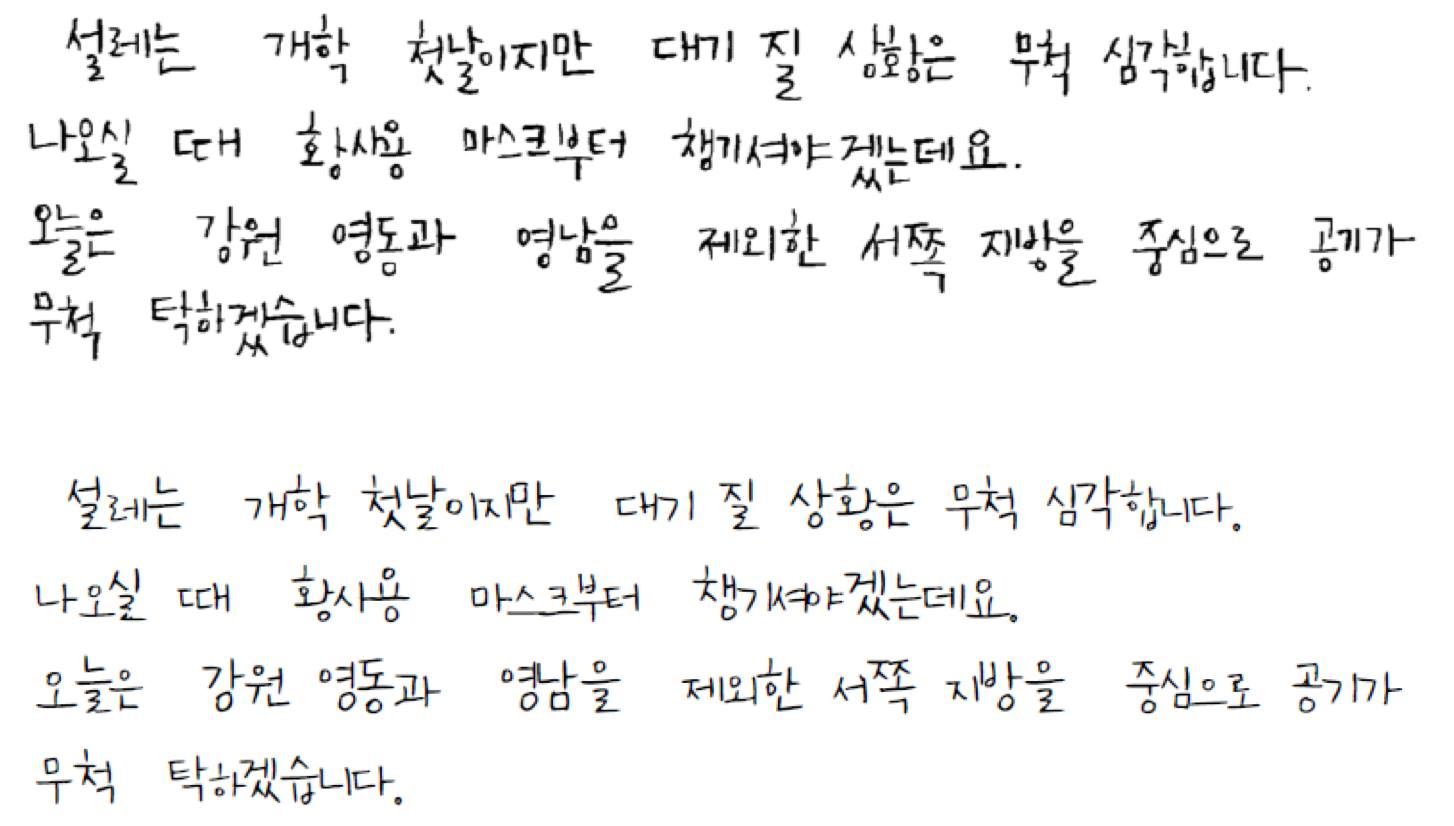


--- OCR 추출 결과 ---
성레는  ,          1 |으
걸레는. 7학 - 전낳디지만 다미 징 한배 4바따-

102      8  ^ㅋ10     *
노상 따1" 218 파스크부터 재거 『겁는데요.
늘으 .깅원 연돔과 명날을

제의관  서재 지바응   죽심으로   2307}
가스                                       !     `르              '
구적   턱하잡니다-

그
설레는  개학 것날지 대1 질 상황은 무적 심각합니다,

다

나
격
듬
애본
싼
-

쟁7야셋는데요

가 가솔
삼우 저외한 서쪽 .방을  중심드로 공기가



In [10]:
# (Colab) 2. OCR 기능 테스트 및 함수화

# 필요한 라이브러리들을 불러옵니다.
import pytesseract
from PIL import Image
import requests
from io import BytesIO

# --- OCR 기능을 함수로 정의 ---
def ocr_image(image_source):
    """
    이미지 소스(URL 또는 파일 경로)를 받아 텍스트를 추출하는 함수
    """
    try:
        # 이미지 소스가 URL인 경우
        if image_source.startswith('http'):
            response = requests.get(image_source)
            img = Image.open(BytesIO(response.content))
        # 이미지 소스가 파일 경로인 경우
        else:
            img = Image.open(image_source)

        # pytesseract를 사용하여 한국어 텍스트 추출
        text = pytesseract.image_to_string(img, lang='kor')
        return text
    except Exception as e:
        return f"OCR 처리 중 오류가 발생했습니다: {e}"


# --- 테스트 실행 ---
# 테스트용 손글씨 이미지 URL
handwriting_image_url = "https://scontent-gmp1-1.xx.fbcdn.net/v/t1.6435-9/70258633_2630183167067192_3990673398563864576_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=33274f&_nc_ohc=z4R6LUqukO8Q7kNvwF-ZQ7c&_nc_oc=AdkxdvIg3bijX1cjsNQtlqQketOiuH9RBnFDEJUO5mNuAcjEHo8My7lyMpZBQtTidb8&_nc_zt=23&_nc_ht=scontent-gmp1-1.xx&_nc_gid=XwnpjwpuKN0aMcRc5N5sQA&oh=00_AfTe4WhuPdObFOcvc2PQV_AtI17K-X3tjJFJtgyE_DAkNw&oe=689C5179"

print("테스트용 손글씨 이미지로 OCR을 실행합니다...")
print(f"이미지 URL: {handwriting_image_url}")

# 웹에서 이미지 바로 표시
try:
    response = requests.get(handwriting_image_url)
    img_for_display = Image.open(BytesIO(response.content))
    display(img_for_display)
except Exception as e:
    print(f"이미지를 표시하는 데 실패했습니다: {e}")


# OCR 함수 호출 및 결과 출력
extracted_text = ocr_image(handwriting_image_url)

print("\n--- OCR 추출 결과 ---")
print(extracted_text)

In [11]:
# (Colab) 2-1. 이미지 전처리 기능이 추가된 OCR 함수

# 이미지 처리를 위한 OpenCV 라이브러리 설치
%pip install -q opencv-python-headless

import pytesseract
from PIL import Image
import requests
from io import BytesIO
import cv2  # OpenCV 라이브러리
import numpy as np

# --- OCR 기능을 향상시키는 이미지 전처리 함수 ---
def preprocess_image(image):
    # PIL 이미지를 OpenCV가 처리할 수 있는 형식으로 변환
    img_cv = np.array(image)

    # 1. 흑백으로 변환
    gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

    # 2. 이진화 (Thresholding): 글자와 배경을 명확하게 분리 (값은 조절 가능)
    # Adaptive Thresholding은 조명이 균일하지 않은 이미지에 더 효과적
    binary_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

    # 처리된 이미지를 다시 PIL 이미지로 변환
    return Image.fromarray(binary_img)


# --- 업그레이드된 OCR 함수 ---
def ocr_image_upgraded(image_source):
    try:
        if image_source.startswith('http'):
            response = requests.get(image_source)
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(image_source).convert("RGB")

        # 1. 이미지 전처리 실행
        preprocessed_img = preprocess_image(img)

        # 2. 전처리된 이미지로 텍스트 추출
        text = pytesseract.image_to_string(preprocessed_img, lang='kor')

        # 보기 좋게 빈 줄 제거
        cleaned_text = "\n".join([line for line in text.splitlines() if line.strip()])
        return cleaned_text

    except Exception as e:
        return f"OCR 처리 중 오류가 발생했습니다: {e}"


# --- 테스트 실행 ---
handwriting_image_url = "https://scontent-gmp1-1.xx.fbcdn.net/v/t1.6435-9/70258633_2630183167067192_3990673398563864576_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=33274f&_nc_ohc=z4R6LUqukO8Q7kNvwF-ZQ7c&_nc_oc=AdkxdvIg3bijX1cjsNQtlqQketOiuH9RBnFDEJUO5mNuAcjEHo8My7lyMpZBQtTidb8&_nc_zt=23&_nc_ht=scontent-gmp1-1.xx&_nc_gid=XwnpjwpuKN0aMcRc5N5sQA&oh=00_AfTe4WhuPdObFOcvc2PQV_AtI17K-X3tjJFJtgyE_DAkNw&oe=689C5179"

print("이미지 전처리 후 OCR을 다시 실행합니다...")

# 업그레이드된 OCR 함수 호출
extracted_text_upgraded = ocr_image_upgraded(handwriting_image_url)

print("\n--- 업그레이드된 OCR 추출 결과 ---")
print(extracted_text_upgraded)

이미지 전처리 후 OCR을 다시 실행합니다...

--- 업그레이드된 OCR 추출 결과 ---
실페는.    7   젖났: 지만: 다미 질 ㅅ볼 는  배 삽량 바니타-
나오틸 때!  1 0  마쓰코브 브테  자1셔때접는데요 요
으   2 1                 때
. >ㄷ   장서 러  영도과  명낭승  제외한 서독 자밖응 을    족심으 가.  2071~
4   탁뷔겠습니다:
설레는 | 개학 젖날만 | 대기 잘 상황은 목적 십삭창대.
나로 하자몽: 마스3북더 챙기96섰는터8.
오른 강원 영동과 영남은 | 저띄한 서쑥 지방은 - 즉실로 공51가
(미그       그
우저. 탁포젯습니다


In [12]:
# EasyOCR 라이브러리 설치
%pip install -q easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 17.8 MB/s eta 0:00:00


In [13]:
# (Colab) 2-3. EasyOCR을 사용하는 최종 OCR 함수

import easyocr
from PIL import Image
import requests
from io import BytesIO
import numpy as np

# --- EasyOCR 리더 객체 생성 (GPU 사용) ---
reader = easyocr.Reader(['ko', 'en'], gpu=True) # 한국어와 영어를 인식하도록 설정

# --- EasyOCR을 사용하는 최종 OCR 함수 ---
def ocr_image_with_easyocr(image_source):
    try:
        if image_source.startswith('http'):
            response = requests.get(image_source)
            image_bytes = response.content
        else: # 파일 업로드의 경우
            image_bytes = image_source.read()

        # EasyOCR로 텍스트 인식 실행
        # detail=0 옵션은 텍스트만 추출하라는 의미
        result = reader.readtext(image_bytes, detail=0, paragraph=True)

        # 추출된 텍스트들을 하나의 문자열로 결합
        return "\n".join(result)

    except Exception as e:
        return f"EasyOCR 처리 중 오류가 발생했습니다: {e}"


# --- 테스트 실행 ---
handwriting_image_url = "https://scontent-gmp1-1.xx.fbcdn.net/v/t1.6435-9/70258633_2630183167067192_3990673398563864576_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=33274f&_nc_ohc=z4R6LUqukO8Q7kNvwF-ZQ7c&_nc_oc=AdkxdvIg3bijX1cjsNQtlqQketOiuH9RBnFDEJUO5mNuAcjEHo8My7lyMpZBQtTidb8&_nc_zt=23&_nc_ht=scontent-gmp1-1.xx&_nc_gid=XwnpjwpuKN0aMcRc5N5sQA&oh=00_AfTe4WhuPdObFOcvc2PQV_AtI17K-X3tjJFJtgyE_DAkNw&oe=689C5179"

print("EasyOCR을 사용하여 다시 실행합니다...")

# EasyOCR 함수 호출
extracted_text_easyocr = ocr_image_with_easyocr(handwriting_image_url)

print("\n--- EasyOCR 추출 결과 ---")
print(extracted_text_easyocr)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% CompleteEasyOCR을 사용하여 다시 실행합니다...

--- EasyOCR 추출 결과 ---
설레는 개학 첫날이지만 대기 질 심요은 무 심각 '합니다 나오실 EH 호;상용 마스a무든   챙기서젯는데요. 오은 감원 0 영동과 영남울 제외한   서쪽 지방을 중심으오 공기가 무척   탁어것습나다:
설레는 개학   첫날이지만 대기 질  상황은 무척  심각합니다. 나오실 다 광사용 마스크부터 챙 W국-켓논데요 오늘은 강원   영동과 영남울 제외한   서쪽 지방을 중심으로   공기가 무척 탁혀켓습니다.


## 가상의 답변 생성 후 테스트

In [14]:
# (Colab) 1. 테스트를 위한 가상 학생 답안 생성

# JSON 파일의 '모범답안' 내용을 기반으로, 약간의 논리적 비약과 표현의 아쉬움이 있는 학생 답안을 가정.

student_answer_text = """
통일신라와 영국의 정책은 둘 다 자국의 정체성을 기반으로 했다는 공통점이 있다.
하지만 통일신라는 삼한일통의식이라는 새로운 정체성을 만들어서 미래를 봤고,
영국은 그냥 원래 있던 정체성에 머물러서 브렉시트라는 안 좋은 결과를 만들었다.
그래서 통일신라는 경제나 문화적으로 발전했지만, 영국은 손해만 볼 것 같다.
국가 발전은 미래를 보는 새로운 정체성에서 나온다고 생각한다.
"""

print("--- 가상 학생 답안 준비 완료 ---")
print(student_answer_text)

--- 가상 학생 답안 준비 완료 ---

통일신라와 영국의 정책은 둘 다 자국의 정체성을 기반으로 했다는 공통점이 있다. 
하지만 통일신라는 삼한일통의식이라는 새로운 정체성을 만들어서 미래를 봤고, 
영국은 그냥 원래 있던 정체성에 머물러서 브렉시트라는 안 좋은 결과를 만들었다. 
그래서 통일신라는 경제나 문화적으로 발전했지만, 영국은 손해만 볼 것 같다. 
국가 발전은 미래를 보는 새로운 정체성에서 나온다고 생각한다.



## 논술 첨삭을 위한 RAG 체인 구성

In [15]:
# (Colab) 2. 논술 첨삭을 위한 RAG 체인 구성

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# --- 필요한 부품 준비 ---
llm = ChatOpenAI(model_name="gpt-4.1-nano", temperature=0.7)
output_parser = StrOutputParser()
retriever = vector_db.as_retriever()

# --- 첨삭 프롬프트 템플릿 ---
prompt_template = """
[역할]
당신은 대치동에서 10년간 논술을 가르친, 냉철하지만 애정 어린 조언을 아끼지 않는 스타강사 '논리왕 김멘토'입니다. 학생의 눈높이에 맞춰 핵심을 꿰뚫는 '팩트 폭격'과 따뜻한 격려를 겸비한 첨삭 스타일로 유명합니다.

[입력 정보]
1. [채점 기준]: {retrieved_scoring_criteria}
2. [모범 답안]: {retrieved_model_answer}
3. [학생 답안]: {user_ocr_answer}

[첨삭 절차 및 지시]
당신은 아래 4단계의 사고 과정을 거쳐, 최종 첨삭문을 [출력 형식]에 맞춰 생성해야 합니다.
1. (이해): 먼저, [학생 답안]을 한 문단씩 읽으며 전체적인 논리의 흐름과 핵심 주장을 파악합니다.
2. (비교): 그 다음, 학생 답안의 각 문단이 [채점 기준]의 어떤 항목에 부합하는지, 그리고 [모범 답안]의 논리 구조와 어떻게 다른지 비교 분석합니다.
3. (평가): 분석한 내용을 바탕으로, 각 항목별로 구체적인 칭찬과 개선점을 정리합니다.
4. (종합): 마지막으로, 이 모든 내용을 종합하여 아래 [출력 형식]에 맞춰 최종 첨삭문을 작성합니다.

[출력 형식]
---
**[총평]**
(학생 답안의 전반적인 강점과 약점을 2~3문장으로 날카롭게 요약)

**[잘한 점 (칭찬 포인트) 👍]**
- (채점 기준과 비교하여, 학생 답안이 어떤 점에서 훌륭한지 구체적인 근거와 문장을 인용하여 칭찬)

**[아쉬운 점 (개선 포인트) ✍️]**
- (모범답안과 비교하여, 어떤 부분을 보완하면 더 좋은 글이 될 수 있을지 구체적으로 제안)

**[이렇게 바꿔보세요 (대안 문장 제안) 💡]**
- (아쉬운 점으로 지적된 문장 1~2개를, 더 논리적이고 세련된 문장으로 직접 수정해서 제안. '기존 문장' -> '수정 제안' 형식으로 제시)

**[예상 점수 및 다음 학습 팁 🚀]**
- (채점 기준을 근거로 예상 점수를 제시하고, 이 학생이 다음번에 더 성장하기 위한 구체적인 학습 팁을 1가지 제안)
---
"""
prompt = ChatPromptTemplate.from_template(prompt_template)

# --- RAG 체인 조립 ---
correction_chain = (
    {
        # retriever를 두 번 사용하여 각각 '모범답안'과 '채점기준'을 검색
        "retrieved_model_answer": RunnableLambda(lambda x: retriever.invoke(f"{x['question_info']} 모범답안")),
        "retrieved_scoring_criteria": RunnableLambda(lambda x: retriever.invoke(f"{x['question_info']} 채점기준")),
        "user_ocr_answer": RunnablePassthrough()
    }
    | prompt
    | llm
    | output_parser
)

print("✅ AI 논술 첨삭 RAG 체인이 완성되었습니다.")

✅ AI 논술 첨삭 RAG 체인이 완성되었습니다.


In [17]:
# (Colab) 3. AI 멘토 첨삭 실행 (수정된 버전)

# 첨삭할 문제 정보와 학생 답안을 함께 전달
input_data = {
    "question_info": "2023년 한국외국어대학교 인문논술 문제 2번",
    "user_ocr_answer": student_answer_text
}

print("\n--- AI 논술 멘토의 첨삭을 시작합니다. ---")
# st.spinner 대신 print 문으로 사용자에게 진행 상황을 알려줍니다.
print("학생 답안을 꼼꼼하게 읽고 첨삭을 생성하고 있습니다... (시간이 걸릴 수 있습니다)")

# RAG 체인을 실행하여 첨삭 결과를 받습니다.
correction_result = correction_chain.invoke(input_data)

# 최종 첨삭 결과를 출력합니다.
print("\n--- 최종 첨삭 결과 ---")
print(correction_result)


--- AI 논술 멘토의 첨삭을 시작합니다. ---
학생 답안을 꼼꼼하게 읽고 첨삭을 생성하고 있습니다... (시간이 걸릴 수 있습니다)

--- 최종 첨삭 결과 ---
---
**[총평]**  
학생 답안은 간단명료하게 두 정책의 차이와 결과를 비교하는 핵심 내용을 담고 있으나, 논리적 전개와 구체적 근거, 세부 설명이 부족하여 전체적인 설득력이 떨어집니다. 또한, 정체성 개념의 확장이나 정책의 의미를 충분히 설명하지 않아 답안의 깊이와 완성도가 낮습니다.  

**[잘한 점 (칭찬 포인트) 👍]**  
- "통일신라는 삼한일통의식이라는 새로운 정체성을 만들어서 미래를 봤고"라는 문장은 핵심 개념을 명확히 제시했으며, 두 정책의 차이를 간단히 표현하려는 의도가 잘 드러납니다.  
- 국가 발전의 관점에서 결과를 평가한 부분은 핵심 내용을 짧게 요약하려는 시도는 좋았으며, 정책의 차별성을 간결하게 보여줍니다.  

**[아쉬운 점 (개선 포인트) ✍️]**  
- 논리의 흐름이 매끄럽지 않고, 구체적 설명과 근거가 부족하여 설득력이 떨어집니다. 예를 들어, "미래를 봤고"라는 표현은 너무 포괄적이고 모호하며, 각각의 정책이 어떻게 경제·문화·국제적 발전에 기여했는지 상세 설명이 필요합니다.  
- 비교 대상인 두 정책의 배경과 결과를 좀 더 구체적으로 설명하지 않아 이해가 어렵고, 두 사례의 차이점을 명확히 구별하는 데 부족함이 있습니다.  
- 답안이 너무 간략하고, 채점 기준에서 요구하는 내용(장기 전략, 문화융합, 국제 위상 등)을 충분히 반영하지 못하고 있습니다.  

**[이렇게 바꿔보세요 (대안 문장 제안) 💡]**  
- 기존 문장: "통일신라는 삼한일통의식이라는 새로운 정체성을 만들어서 미래를 봤고"  
  -> 수정 제안: "통일신라는 삼한일통의식을 새롭게 확립하여, 이를 바탕으로 장기적인 국가 통합과 발전을 도모하였다."  
- 기존 문장: "영국은 그냥 원래 있던 정체성에 머물러서 브렉시트라는 안 좋은 결과를 만들었다."  
  -> 수정

## 모범답안과 학생 답안을 비교할 수 있는 기능 추가

In [21]:
# (Colab) 최종 AI 논술 멘토 (시각적 비교 기능 추가)

# 필요한 라이브러리
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
import re
import difflib # 텍스트 비교를 위한 라이브러리
from IPython.display import display, HTML # Colab에서 HTML을 예쁘게 보여주기 위함

# --- 필요한 부품 준비 ---
llm = ChatOpenAI(model_name="gpt-4.1-nano", temperature=0.7)
output_parser = StrOutputParser()
retriever = vector_db.as_retriever()

# --- 업그레이드된 첨삭 프롬프트 템플릿 ---
prompt_template = """
[역할]
당신은 대치동에서 10년간 논술을 가르친, 냉철하지만 애정 어린 조언을 아끼지 않는 스타강사 '논리왕 김멘토'입니다. 학생의 눈높이에 맞춰 핵심을 꿰뚫는 '팩트 폭격'과 따뜻한 격려를 겸비한 첨삭 스타일로 유명합니다.

[입력 정보]
1. [채점 기준]: {retrieved_scoring_criteria}
2. [모범 답안]: {retrieved_model_answer}
3. [학생 답안]: {user_ocr_answer}

[첨삭 절차 및 지시]
당신은 아래 4단계의 사고 과정을 거쳐, 최종 첨삭문을 [출력 형식]에 맞춰 생성해야 합니다.
1. (이해): 먼저, [학생 답안]을 한 문단씩 읽으며 전체적인 논리의 흐름과 핵심 주장을 파악합니다.
2. (비교): 그 다음, 학생 답안의 각 문단이 [채점 기준]의 어떤 항목에 부합하는지, 그리고 [모범 답안]의 논리 구조와 어떻게 다른지 비교 분석합니다.
3. (평가): 분석한 내용을 바탕으로, 각 항목별로 구체적인 칭찬과 개선점을 정리합니다.
4. (종합): 마지막으로, 이 모든 내용을 종합하여 아래 [출력 형식]에 맞춰 최종 첨삭문을 작성합니다.

[출력 형식]
---
**[총평]**
(학생 답안의 전반적인 강점과 약점을 2~3문장으로 날카롭게 요약)

**[잘한 점 (칭찬 포인트) 👍]**
- (채점 기준과 비교하여, 학생 답안이 어떤 점에서 훌륭한지 구체적인 근거와 문장을 인용하여 칭찬)

**[아쉬운 점 (개선 포인트) ✍️]**
- (모범답안과 비교하여, 어떤 부분을 보완하면 더 좋은 글이 될 수 있을지 구체적으로 제안)

**[이렇게 바꿔보세요 (대안 문장 제안) 💡]**
- (아쉬운 점으로 지적된 문장 1~2개를, 더 논리적이고 세련된 문장으로 직접 수정해서 제안합니다. 반드시 "학생 원문: ..." -> "수정 제안: ..." 형식을 정확히 지켜서 여러 개를 작성해주세요.)

**[예상 점수 및 다음 학습 팁 🚀]**
- (채점 기준을 근거로 예상 점수를 제시하고, 이 학생이 다음번에 더 성장하기 위한 구체적인 학습 팁을 1가지 제안)
---
"""
prompt = ChatPromptTemplate.from_template(prompt_template)

# --- RAG 체인 조립 ---
correction_chain = (
    {
        "retrieved_model_answer": RunnableLambda(lambda x: retriever.invoke(f"{x['question_info']} 모범답안")),
        "retrieved_scoring_criteria": RunnableLambda(lambda x: retriever.invoke(f"{x['question_info']} 채점기준")),
        "user_ocr_answer": lambda x: x["user_ocr_answer"]
    }
    | prompt
    | llm
    | output_parser
)

# --- 첨삭 결과 후처리 및 시각화 함수 ---
def display_correction_with_diff(student_answer, model_answer_text, correction_result):
    # '이렇게 바꿔보세요' 섹션 파싱
    suggestions = re.findall(r'학생 원문: (.*?)\s*->\s*수정 제안: (.*?)\n', correction_result, re.DOTALL)

    # 원본 첨삭 결과에서 제안 부분은 제외하고 출력
    main_correction = re.split(r'(\*\*\[이렇게 바꿔보세요)', correction_result)[0]

    # HTML로 결과 표시
    html = f"""
    <div style="display: flex; gap: 20px; font-family: sans-serif;">
        <div style="flex: 1; border: 1px solid #ddd; padding: 15px; border-radius: 8px;">
            <h3 style="border-bottom: 2px solid #ddd; padding-bottom: 10px;">👨‍🎓 학생 답안</h3>
            <p style="white-space: pre-wrap;">{student_answer}</p>
        </div>
        <div style="flex: 1; border: 1px solid #ddd; padding: 15px; border-radius: 8px;">
            <h3 style="border-bottom: 2px solid #ddd; padding-bottom: 10px;">✅ 모범 답안</h3>
            <p style="white-space: pre-wrap;">{model_answer_text}</p>
        </div>
    </div>
    <div style="margin-top: 20px; border: 1px solid #007bff; padding: 15px; border-radius: 8px; font-family: sans-serif;">
        <h3 style="border-bottom: 2px solid #007bff; padding-bottom: 10px; color: #007bff;">🤖 AI 멘토 첨삭</h3>
        <div style="white-space: pre-wrap;">{main_correction}</div>
    """

    if suggestions:
        html += '<h4 style="margin-top: 20px;">💡 이렇게 바꿔보세요</h4>'
        for original, suggestion in suggestions:
            d = difflib.Differ()
            diff = d.compare(original.split(), suggestion.split())
            diff_html = ""
            for word in diff:
                if word.startswith('+ '):
                    diff_html += f'<span style="background-color: #d4edda;">{word[2:]}</span> '
                elif word.startswith('- '):
                    diff_html += f'<span style="background-color: #f8d7da; text-decoration: line-through;">{word[2:]}</span> '
                elif word.startswith('? '):
                    continue
                else:
                    diff_html += f'{word[2:]} '

            html += f'<div style="border: 1px solid #ccc; padding: 10px; border-radius: 5px; margin-top: 10px;"><p><strong>원본:</strong> {original.strip()}</p><p><strong>제안:</strong> {diff_html.strip()}</p></div>'

    html += "</div>"
    display(HTML(html))

In [22]:
# --- 최종 테스트 실행 ---
student_answer_text = """
통일신라와 영국의 정책은 둘 다 자국의 정체성을 기반으로 했다.
하지만 통일신라는 삼한일통의식이라는 새로운 정체성을 만들어서 미래를 봤고,
영국은 그냥 원래 있던 정체성에 머물러서 브렉시트라는 안 좋은 결과를 만들었다.
그래서 통일신라는 경제나 문화적으로 발전했지만, 영국은 손해만 볼 것 같다.
국가 발전은 미래를 보는 새로운 정체성에서 나온다고 생각한다.
"""
question_info = "2023년 한국외국어대학교 인문논술 문제 2번"

# 1. 학생 답안에 대한 첨삭 생성
correction_result = correction_chain.invoke({
    "question_info": question_info,
    "user_ocr_answer": student_answer_text
})

# 2. 비교를 위한 모범답안 원문 검색
model_answer_docs = retriever.invoke(f"{question_info} 모범답안")
model_answer_text = model_answer_docs[0].page_content if model_answer_docs else "모범답안을 찾을 수 없습니다."

# 3. 시각화 함수 호출
display_correction_with_diff(student_answer_text, model_answer_text, correction_result)